# **2.2 Likelihood of a Tree Graphical Model**



In [ ]:
from collections import defaultdict
import numpy as np
from Tree import Tree, Node

def childrenOf(node, topology):
    children = []
    for index, parent in enumerate(topology):
        if parent == node:
            children.append(index)
    return children


def CPD(theta, node, k, parent_cat=None):
    if parent_cat is None:
        return theta[node][k]
    else:
        return theta[node][parent_cat][k]

    
def calculate_likelihood(tree_topology, theta, beta):
    print("-----------------------------------------")
    print("Calculating the likelihood...")

    s_dict = defaultdict(dict)
    
    ##########################################################################################################
    def S(node, k, children):
      if s_dict[node].get(k) is not None:
        return s_dict[node].get(k)
      if len(children) == 0:
        if beta[node] == k:
          s_dict[node][k] = 1
          return 1
        else:
          s_dict[node][k] = 0
          return 0

      children_1 = 0
      children_2 = 0

      N = len(theta[0])
      for j in range(N):
        children_1 += S(children[0], j, childrenOf(children[0], tree_topology)) * CPD(theta, children[0], j, k)
        children_2 += S(children[1], j, childrenOf(children[1], tree_topology)) * CPD(theta, children[1], j, k)

      s_final = children_1 * children_2
      s_dict[node][k] = s_final

      return s_final    

      ##########################################################################################################

    likelihood = 0
    N = len(theta[0])
      
    for k in range(N):
      likelihood += S(0, k, childrenOf(0 , tree_topology)) * CPD(theta, 0, k)

    return likelihood




In [ ]:
def main():
    print("Hello World!")
    print("This file is the solution template for question 2.2.")

    print("\n1. Load tree data from file and print it\n")

    #filename = "q2_2_small_tree.pkl"  
    #filename = "q2_2_medium_tree.pkl"
    filename = "q2_2_large_tree.pkl"
    t = Tree()
    t.load_tree(filename)
    t.print()
    print("K of the tree: ", t.k, "\talphabet: ", np.arange(t.k))

    print("\n2. Calculate likelihood of each FILTERED sample\n")
    # These filtered samples already available in the tree object.
    # Alternatively, if you want, you can load them from corresponding .txt or .npy files

    for sample_idx in range(t.num_samples):
        beta = t.filtered_samples[sample_idx]
        print("\n\tSample: ", sample_idx, "\tBeta: ", beta)
        sample_likelihood = calculate_likelihood(t.get_topology_array(), t.get_theta_array(), beta.astype(int))
        print("\tLikelihood: ", sample_likelihood)


if __name__ == "__main__":
    main()

# **2.3 Simple Variational Inference**

In [ ]:
import numpy as np

def calc_an(a0, N):
  return a0 + N/2

def calc_bn(b0, e_mu):
  return b0 + e_mu

def calc_mun(lambda_0, mu_0, N, X):
  return (lambda_0*mu_0 + N*np.average(X))/(lambda_0 + N)

def calc_lambdan(lambda_0, Etau, N):
  return (lambda_0 + N)*Etau

def e_mu(lambda_n, mu_n, X, mu_0, lambda_0):
  # E(mu**2) = Var(mu) +(E(mu))**2
  e_mu2 = 1/lambda_n + mu_n**2

  #E(cA + B) = cE(A) + E(B)
  term1 = np.sum(X**2 - 2*X*mu_n + e_mu2)
  term2 = lambda_0 * (e_mu2 - 2 * mu_n * mu_0 + mu_0**2)

  return (1/2)*(term1+term2)

def variational_inference(iterations, EtauG, lambda_0, mu_0, a0, b0, X):

  N = len(X)
  Etau = EtauG

  for i in range(iterations):
    mu_n = calc_mun(lambda_0, mu_0, N, X)
    lambda_n = calc_lambdan(lambda_0, Etau, N)
    a_n = calc_an(a0, N)
    b_n = calc_bn(b0, e_mu(lambda_n, mu_n, X, mu_0, lambda_0))

    Etau = a_n/b_n

  return mu_n, lambda_n, a_n, b_n



## **Generate data**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D


# Generate a random gaussian distribution 
def gen_data(mean, sd, N):
  return np.random.normal(mean, sd, N)

# Densities functions
def pdf_norm(x, mean, precision):
    return stats.norm.pdf(x, mean, np.sqrt(1/precision))

def pdf_gamma(tau, a, b):
    return stats.gamma.pdf(tau, a, loc=0, scale=(1 / b))

# likelihood, to compute the posterior
def likelihood(X, mu, tau):
    N = len(X)
    D = (tau / (2 * np.pi)) ** (N / 2) * np.exp(-(tau / 2) * np.sum((X - mu) ** 2))
    return D


In [ ]:
# Our data parameters
N = 50
mu = 1
lamb = 1
a = 1
b = 1

# Our data
mean = mu
precision = a/b
sd = np.sqrt(1/precision)

X = gen_data(mean, sd, N)


In [ ]:
#VI, inf for inferred
inf_mu, inf_lamb, inf_a, inf_b = variational_inference(10, 1, 0, 0, 0, 0, X)

In [ ]:
def plot_function(X, vi_parameters=None):
    if vi_parameters != None:
      m_i, lamb_i, a_i, b_i = vi_parameters[0], vi_parameters[1], vi_parameters[2], vi_parameters[3]  

    mus = np.linspace(mean - 0.5, mean + 0.5, 100)
    taus = np.linspace(precision - 1, precision + 1, 100)
    M, T = np.meshgrid(mus, taus, indexing="ij")
    Z = np.zeros_like(M)

    if vi_parameters != None:
      for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
          Z[i][j] = pdf_norm(mus[i], m_i, lamb_i) * pdf_gamma(taus[j], a_i, b_i)
      plt.contour(M, T, Z, 5, colors='blue')
    else:
      for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
          Z[i][j] = pdf_norm(mus[i], mean, lamb*taus[j]) * pdf_gamma(taus[j], a, b) * likelihood(X, mus[i], taus[j])
      plt.contour(M, T, Z, 5, colors='green')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in double_scalars
  


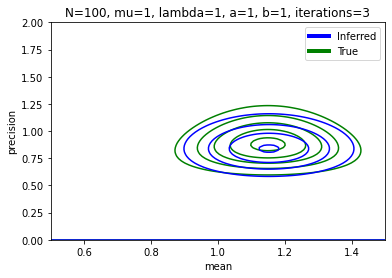

In [ ]:
#plot
custom_lines = [Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="green", lw=4)]

fig, ax = plt.subplots()
ax.legend(custom_lines, ['Inferred', 'True'])
plot_function(X)
plot_function(X, [inf_mu, inf_lamb, inf_a, inf_b])
plt.xlabel("mean")
plt.ylabel("precision")
plt.title('N=100, mu=1, lambda=1, a=1, b=1, iterations=3')
plt.show()

# **2.4 Mixture of trees with observable variables**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from Kruskal_v1 import Graph
from Tree import TreeMixture, Tree, Node
import sys
import dendropy

epsilon = sys.float_info.epsilon


def save_results(loglikelihood, topology_array, theta_array, filename):
    """ This function saves the log-likelihood vs iteration values,
        the final tree structure and theta array to corresponding numpy arrays. """

    likelihood_filename = filename + "_em_loglikelihood.npy"
    topology_array_filename = filename + "_em_topology.npy"
    theta_array_filename = filename + "_em_theta.npy"
    print("Saving log-likelihood to ", likelihood_filename, ", topology_array to: ", topology_array_filename,
          ", theta_array to: ", theta_array_filename, "...")
    np.save(likelihood_filename, loglikelihood)
    np.save(topology_array_filename, topology_array)
    np.save(theta_array_filename, theta_array)


def em_algorithm(seed_val, samples, num_clusters, max_num_iter=100):
    """
    This function is for the EM algorithm.
    :param seed_val: Seed value for reproducibility. Type: int
    :param samples: Observed x values. Type: numpy array. Dimensions: (num_samples, num_nodes)
    :param num_clusters: Number of clusters. Type: int
    :param max_num_iter: Maximum number of EM iterations. Type: int
    :return: loglikelihood: Array of log-likelihood of each EM iteration. Type: numpy array.
                Dimensions: (num_iterations, ) Note: num_iterations does not have to be equal to max_num_iter.
    :return: topology_list: A list of tree topologies. Type: numpy array. Dimensions: (num_clusters, num_nodes)
    :return: theta_list: A list of tree CPDs. Type: numpy array. Dimensions: (num_clusters, num_nodes, 2)

    This is a suggested template. Feel free to code however you want.
    """

    print("Running EM algorithm...")

    # Set threshold for convergence
    THRES = 1e-4
    
    num_sieving = 10
    num_samples = np.size(samples, 0)
    num_nodes = np.size(samples, 1)
    
    np.random.seed(seed_val)
    seeds = np.random.randint(0, 100000000, num_sieving)
    last_loglikelihoods = []
    tms = []
    for seed in seeds:
        np.random.seed(seed)
        tm = TreeMixture(num_clusters=num_clusters, num_nodes=num_nodes)
        tm.simulate_pi(seed_val=seed)
        tm.simulate_trees(seed_val=seed)
        tm_loglikelihood, tm = em_steps(tm, samples, num_clusters, max_num_iter=10)
        last_loglikelihoods.append(tm_loglikelihood[-1])
        tms.append(tm)

    print("=> Sieving finished")
    seed = seeds[last_loglikelihoods.index(max(last_loglikelihoods))]
    tm = TreeMixture(num_clusters=num_clusters, num_nodes=num_nodes)
    tm.simulate_pi(seed_val=seed)
    tm.simulate_trees(seed_val=seed)
    loglikelihood, tm = em_steps(tm, samples, num_clusters, max_num_iter=max_num_iter)

    print("=> EM finished")
    topology_list = []
    theta_list = []
    for t in tm.clusters:
        topology_list.append(t.get_topology_array())
        theta_list.append(t.get_theta_array())
    loglikelihood = np.array(loglikelihood)
    topology_list = np.array(topology_list)

    return loglikelihood, topology_list, theta_list, tm

In [ ]:
def compute_r(N, num_clusters, samples, tree, num_nodes, epsilon, loglikelihood):
  r = np.ones((N, num_clusters))

  for n, x in enumerate(samples):
    for k, ct in enumerate(tree.clusters):
      r[n,k] *= tree.pi[k]

      ct_nodes_tovisit = [ct.root]
      num_visited_nodes = 1
        
      while num_visited_nodes <= num_nodes:
        curr_node = ct_nodes_tovisit.pop(0)
        ct_nodes_tovisit = ct_nodes_tovisit + curr_node.descendants
        if num_visited_nodes == 1:
          root_cat = x[int(curr_node.name)]
          r[n,k] *= curr_node.cat[root_cat]
        else:
          parent_cat = x[int(curr_node.ancestor.name)]
          node_cat = x[int(curr_node.name)]
          r[n,k] *= curr_node.cat[parent_cat][node_cat]

        num_visited_nodes +=1

  r += epsilon
  marginal = np.reshape(np.sum(r, axis=1), (N, 1))
  loglikelihood.append(np.sum(np.log(marginal)))
  marginal_expand = np.repeat(marginal, num_clusters, axis=1)
  r /= marginal_expand 

  return r

def find_indexes(samples,s,t,a,b):
  cond = samples[:,(s,t)]==[a,b]
  indexes = []
  for i,e in enumerate(cond):
    if e[0] == e[1] and e[0] == True:
      indexes.append(i)
  return indexes

def compute_I(r, num_nodes, num_clusters, samples):
  denom = np.sum(r, axis=0)
  q = np.zeros((num_nodes, num_nodes, 2, 2, num_clusters)) # (s, t, a, b, k)
  for s in range(num_nodes):
       for t in range(num_nodes):
          for a in range(2):
              for b in range(2):
                  indexes = find_indexes(samples,s,t,a,b)
                  # indexes = np.where((samples[:,(s,t)]==[a,b]).all(1))[0]
                  q[s, t, a, b] = np.sum(r[indexes], axis=0) / denom
  q += epsilon

  q_s = np.zeros((num_nodes, 2, num_clusters))
  for s in range(num_nodes):
      for a in range(2):
          index = np.where(samples[:, s]==a)
          q_s[s,a] = np.sum(r[index], axis=0) / denom
  q_s += epsilon

  I = np.zeros((num_nodes, num_nodes, num_clusters)) # (s, t, k)
  for s in range(num_nodes):
      for t in range(num_nodes):
           for a in range(2):
               for b in range(2):
                  I[s,t] += q[s,t,a,b] * np.log(q[s,t,a,b] / (q_s[s,a]*q_s[t,b]))
                  # I[s,t] += q[s,t,a,b] * np.log(q[s,t,a,b] / (q[s,s,a,a]*q[t,t,b,b]))

  return I, q, q_s


def construct_MST(edges, num_nodes):
  topology_array = np.zeros(num_nodes)
  topology_array[0] = np.nan

  visited_nodes = [0]
  num_visited_nodes = 1
  
  while num_visited_nodes <= num_nodes:
    curr_node = visited_nodes.pop(0)
    childs = []
    # print("EDGES: ", edges, "curr_node: ", curr_node)

    to_remove = []
    for e in edges:
      if e[0] == curr_node:
        childs.append(e[1])
        to_remove.append(e)
        # print("node: ", e, "to remove: ", to_remove)
      elif e[1] == curr_node:
        childs.append(e[0])
        to_remove.append(e)
        # print("node: ", e, "to remove: ", to_remove)

    for e in to_remove:
      edges.remove(e)
    
    for child in childs:
      # print("Curr node: ", curr_node, " Childs:", childs)
      topology_array[int(child)] = curr_node
      visited_nodes.append(int(child))

    num_visited_nodes += 1

  # print(topology_array)

  tree = Tree()
  tree.load_tree_from_direct_arrays(topology_array)
  tree.k = 2
  tree.alpha = [1.0] * 2

  return tree


def update_CPD(mst, num_nodes, q, q_s, k):
  visited_nodes = [mst.root]
  num_visited_nodes = 1

  while num_visited_nodes <= num_nodes:
    curr_node = visited_nodes.pop(0)
    visited_nodes = visited_nodes + curr_node.descendants

    if num_visited_nodes == 1:
      curr_node.cat = q_s[int(curr_node.name),:,k].tolist()
      # print("LALAAL ", curr_node.cat, q[int(curr_node.name),int(curr_node.name),:,:,k])
      # curr_node.cat = q[int(curr_node.name),int(curr_node.name),:,:,k].tolist()
    else:
      cat = q[int(curr_node.ancestor.name),int(curr_node.name),:,:,k]
      curr_node.cat = [cat[0], cat[1]]

    num_visited_nodes += 1


In [ ]:
def em_steps(tree, samples, num_clusters, max_num_iter=100):
  N = np.size(samples, 0)
  num_nodes = np.size(samples, 1)
  loglikelihood = []

  for i in range(max_num_iter):

    # Step 1--------------------------------------------------------------------
    r = compute_r(N, num_clusters, samples, tree, num_nodes, epsilon, loglikelihood)
          
    # Step 2--------------------------------------------------------------------      
    tree.pi = np.mean(r, axis=0)

    # Step 3-------------------------------------------------------------------- 
    I, q, q_s = compute_I(r, num_nodes, num_clusters, samples)

    clusters = []
    for k in range(num_clusters):
      g = Graph(num_nodes)
      for s in range(num_nodes):
        for t in range(s+1, num_nodes):
          g.addEdge(s, t, I[s, t ,k])


    # Step 4-------------------------------------------------------------------- 
      mst_edges = g.maximum_spanning_tree()
      mst = construct_MST(mst_edges, num_nodes)

    # Step 5-------------------------------------------------------------------- 
      update_CPD(mst, num_nodes, q, q_s, k)

    #---------------------------------------------------------------------------
      clusters.append(mst)

    tree.clusters = clusters

  return loglikelihood, tree


In [ ]:
def compute_RF(true_tree, inferred_tree):
  num_samples, num_nodes = true_tree.samples.shape
  num_clusters = true_tree.num_clusters
  tns = dendropy.TaxonNamespace()
  print("\\hline")
  for k in range(num_clusters):
      print(k, end=" ")
      for j in range(num_clusters):
          t_0 = inferred_tree.clusters[k]
          t_0.get_tree_newick()
          t_0 = dendropy.Tree.get(data=t_0.newick, schema="newick", taxon_namespace=tns)
          t_t = true_tree.clusters[j]
          t_t.get_tree_newick()
          t_t = dendropy.Tree.get(data=t_t.newick, schema="newick", taxon_namespace=tns)
          print(dendropy.calculate.treecompare.symmetric_difference(t_0, t_t), end=" ")
      print("\\\\")


def true_likelihood(true_tree, samples):
  num_samples, num_nodes = samples.shape
  num_clusters = true_tree.num_clusters
  posterior = np.ones((num_samples, num_clusters))
  prior = np.ones(num_samples)
  for n, x in enumerate(samples):
      for k, tree in enumerate(true_tree.clusters):
          visited_nodes = [tree.root]
          num_visited_nodes = 1
          while num_visited_nodes <= num_nodes:
              curr_node = visited_nodes.pop(0)
              visited_nodes = visited_nodes + curr_node.descendants
              if num_visited_nodes == 1:
                curr_cat = x[int(curr_node.name)]
                posterior[n,k] *= curr_node.cat[curr_cat]
              else:
                parent_cat = x[int(curr_node.ancestor.name)]
                curr_cat = x[int(curr_node.name)]
                posterior[n,k] *= curr_node.cat[parent_cat][curr_cat] 
              
              num_visited_nodes += 1

      prior[n] *= np.sum(posterior[n] * true_tree.pi)

  return np.sum(np.log(prior))

In [ ]:
def main():
    print("Hello World!")
    print("This file demonstrates the flow of function templates of question 2.4.")

    seed_val = 123

    sample_filename = "q2_4_tree_mixture.pkl_samples.txt"
    output_filename = "q2_4_results.txt"
    real_values_filename = "q2_4_tree_mixture.pkl"

    # sample_filename = "q2_4_tree_mixture.pkl_tree_0_samples.txt"
    # output_filename = "q2_4_results.txt"
    # real_values_filename = "q2_4_tree_mixture-0.pkl"

    num_clusters = 3

    print("\n1. Load samples from txt file.\n")

    # true_tree = TreeMixture(0, 0)
    # true_tree.load_mixture(real_values_filename)
    # true_samples = true_tree.samples

    # samples = np.loadtxt(sample_filename, delimiter="\t", dtype=np.int32)
    # num_samples, num_nodes = samples.shape
    # print("\tnum_samples: ", num_samples, "\tnum_nodes: ", num_nodes)
    # print("\tSamples: \n", samples)

    S=1000
    N=3
    C=6

    true_tree = TreeMixture(num_clusters=C, num_nodes=N)
    true_tree.simulate_pi(seed_val=seed_val)
    true_tree.simulate_trees(seed_val=seed_val)
    true_tree.sample_mixtures(S, seed_val=seed_val)
    samples = true_tree.samples
    num_samples, num_nodes = samples.shape

    print("\n2. Run EM Algorithm.\n")

    loglikelihood, topology_array, theta_array, tm = em_algorithm(seed_val, samples, num_clusters=C)

    print("\n3. Save, print and plot the results.\n")

    save_results(loglikelihood, topology_array, theta_array, output_filename)

    for i in range(num_clusters):
        print("\n\tCluster: ", i)
        print("\tTopology: \t", topology_array[i])
        print("\tTheta: \t", theta_array[i])

    plt.figure(figsize=(8, 3))
    plt.subplot(121)
    plt.plot(np.exp(loglikelihood), label='Estimated')
    plt.ylabel("Likelihood of Mixture")
    plt.xlabel("Iterations")
    plt.subplot(122)
    plt.plot(loglikelihood, label='Estimated')
    plt.ylabel("Log-Likelihood of Mixture")
    plt.xlabel("Iterations")
    plt.legend(loc=(1.04, 0))
    plt.show()

    if real_values_filename != "":
        print("\n4. Retrieve real results and compare.\n")
        print("\tComparing the results with real values...")

        print("\t4.1. Make the Robinson-Foulds distance analysis.\n")
        compute_RF(true_tree, tm)

        print("\t4.2. Make the likelihood comparison.\n")
        true_l= true_likelihood(true_tree, samples)
        print("Resulted likelihood: %f, True likelihood: %f"%(loglikelihood[-1], true_l))
        print(true_l - loglikelihood[-1])


if __name__ == "__main__":
    main()

In [ ]:
def faire(S,N,C):
    # print("Hello World!")
    # print("This file demonstrates the flow of function templates of question 2.4.")

    seed_val = 123

    sample_filename = "q2_4_tree_mixture.pkl_samples.txt"
    output_filename = "q2_4_results.txt"
    real_values_filename = "q2_4_tree_mixture.pkl"

    # sample_filename = "q2_4_tree_mixture.pkl_tree_0_samples.txt"
    # output_filename = "q2_4_results.txt"
    # real_values_filename = "q2_4_tree_mixture-0.pkl"

    # num_clusters = 3

    # print("\n1. Load samples from txt file.\n")

    # true_tree = TreeMixture(0, 0)
    # true_tree.load_mixture(real_values_filename)
    # true_samples = true_tree.samples

    # samples = np.loadtxt(sample_filename, delimiter="\t", dtype=np.int32)
    # num_samples, num_nodes = samples.shape
    # print("\tnum_samples: ", num_samples, "\tnum_nodes: ", num_nodes)
    # print("\tSamples: \n", samples)

    true_tree = TreeMixture(num_clusters=C, num_nodes=N)
    true_tree.simulate_pi(seed_val=seed_val)
    true_tree.simulate_trees(seed_val=seed_val)
    true_tree.sample_mixtures(S, seed_val=seed_val)
    samples = true_tree.samples
    num_samples, num_nodes = samples.shape

    # print("\n2. Run EM Algorithm.\n")

    loglikelihood, topology_array, theta_array, tm = em_algorithm(seed_val, samples, num_clusters=C)

    # print("\n3. Save, print and plot the results.\n")

    # save_results(loglikelihood, topology_array, theta_array, output_filename)

    # for i in range(num_clusters):
    #     print("\n\tCluster: ", i)
    #     print("\tTopology: \t", topology_array[i])
    #     print("\tTheta: \t", theta_array[i])

    # plt.figure(figsize=(8, 3))
    # plt.subplot(121)
    # plt.plot(np.exp(loglikelihood), label='Estimated')
    # plt.ylabel("Likelihood of Mixture")
    # plt.xlabel("Iterations")
    # plt.subplot(122)
    # plt.plot(loglikelihood, label='Estimated')
    # plt.ylabel("Log-Likelihood of Mixture")
    # plt.xlabel("Iterations")
    # plt.legend(loc=(1.04, 0))
    # plt.show()

    if real_values_filename != "":
        # print("\n4. Retrieve real results and compare.\n")
        # print("\tComparing the results with real values...")

        # print("\t4.1. Make the Robinson-Foulds distance analysis.\n")
        compute_RF(true_tree, tm)

        # print("\t4.2. Make the likelihood comparison.\n")
        true_l= true_likelihood(true_tree, samples)
        print("Resulted likelihood: %f, True likelihood: %f"%(loglikelihood[-1], true_l))
        return true_l - loglikelihood[-1]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.lines import Line2D
from mpl_toolkits.mplot3d import Axes3D

N = 50
true_mu, true_lam, true_a, true_b = 0.8, 1, 8, 5


def gauss_sample(mean, prec):
    return np.random.normal(mean, np.sqrt(prec ** -1))


def gamma_sample(al, be):
    return np.random.gamma(al, 1 / be)


true_mean = true_mu
true_precision = true_a / true_b


# generate random dataset X
def data_set(m, p):
    return np.random.normal(m, np.sqrt(p ** (-1)), N)


# 10.21 ( Generate dataset Y/D)
def likelihood(data, par1, par2):
    N = len(data)
    sum_data = (data - par1) ** 2
    sum_data = np.sum(sum_data)
    D = (par2 / (2 * np.pi)) ** (N / 2) * np.exp(-(par2 / 2) * sum_data)
    return D


# E[mu**2], Needed to calculate b_n
def expected_mu(lamb0, X, mu0, mu_n, lamb_n):
    E_mu2 = lamb_n ** (-1) + mu_n ** 2
    square_sum = np.sum((X ** 2) - (2 * X * mu_n) + E_mu2)
    return (1 / 2 * square_sum) + lamb0 * ((mu0 ** 2) - (2 * mu0 * mu_n) + E_mu2)


def approx_a(a0, n):
    return a0 + ((n + 1) / 2)


def approx_mu(l0, m0, X, n):
    return (l0 * m0 + n * np.average(X)) / (l0 + n)


def approx_lambda(l0, a_n, b_n, n):
    return (l0 + n) * (a_n / b_n)


def approx_b(m0, m_n, l_n, l0, b0):
    return b0 + expected_mu(l0, X, m0, m_n, l_n)


# Once
def VariationalInference(mu0, lamb0, a0, b0, X, iterations):
    i = 0
    la = 1
    be = 1
    mu = mu0
    al = a0
    while i < iterations:
        # a0 = al
        # mu0 = mu
        # lamb0 = la
        # b0 = be
        al = approx_a(a0, N)
        mu = approx_mu(lamb0, mu0, X, N)
        be = approx_b(mu0, mu, la, lamb0, b0)
        la = approx_lambda(lamb0, al, be, N)
        i += 1
        if i == iterations:
            return mu, la, al, be


"""def plot(mean, variance, a, b):
    x_axis = np.arange(-10, 10, 0.001)
    # Mean = 0, SD = 2.
    plt.plot(stats.gamma.pdf(x_axis, a, scale=1 / b), stats.norm.pdf(x_axis, mean, variance ** (-1)))
    plt.show()"""


def q_mu(x, mean, precision):
    return stats.norm.pdf(x, mean, np.sqrt(1 / precision))


def q_tau(tau, alpha, beta):
    return stats.gamma.pdf(tau, alpha, loc=0, scale=(1 / beta))





X = data_set(true_mean, true_precision)
# X = np.array([2.88968457, 6.96566223, 7.04354481, 6.74967938, 8.07064458, 5.77937716,
#              3.722499, 3.30732687, 5.07045578, 4.26291923])

In [ ]:
def true_plot(mean, precision, alpha, beta, data):
    print("Generated mean, tau: " + str(true_mean) + " ," + str(true_precision))
    print("Actual mean, lambda , alpha ,beta: " + str(mean) + " ," + str(precision) + " ," + str(alpha) + " ," + str(
        beta))
    mus = np.linspace(true_mean - 0.5, true_mean + 0.5, 100)
    taus = np.linspace(true_precision - 0.75, true_precision + 0.75, 100)
    M, T = np.meshgrid(mus, taus, indexing="ij")
    Z = np.zeros_like(M)
    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i][j] = q_mu(mus[i], true_mean, true_lam * taus[j]) * q_tau(taus[j], true_a, true_b) * likelihood(data
                                                                                                                ,
                                                                                                                mus[
                                                                                                                    i],
                                                                                                                taus[
                                                                                                                    j])
    plt.contour(M, T, Z, 5, colors='green')


def plot(mean, precision, alpha, beta):
    print("Observed mean, tau: " + str(mean) + " ," + str(alpha / beta))
    print(
        "Observed mean, tau, lambda , alpha ,beta: " + str(mean) + " ," + str(precision) + " ," + str(
            alpha) + " ," + str(
            beta))
    mus = np.linspace(true_mean - 0.5, true_mean + 0.5, 100)
    taus = np.linspace(true_precision - 0.75, true_precision + 0.75, 100)
    M, T = np.meshgrid(mus, taus, indexing="ij")
    Z = np.zeros_like(M)

    for i in range(Z.shape[0]):
        for j in range(Z.shape[1]):
            Z[i][j] = q_mu(mus[i], mean, precision) * q_tau(taus[j], alpha, beta)
    plt.contour(M, T, Z, 5, colors='blue', )
    # plt.scatter(true_mean, true_precision, color="black")

Generated mean, tau: 0.8 ,1.6
Actual mean, lambda , alpha ,beta: 0.8 ,1 ,8 ,5
Observed mean, tau: 0.7283380392457935 ,1.4478167073708315
Observed mean, tau, lambda , alpha ,beta: 0.7283380392457935 ,72.39083536854157 ,25.5 ,17.612726714769597


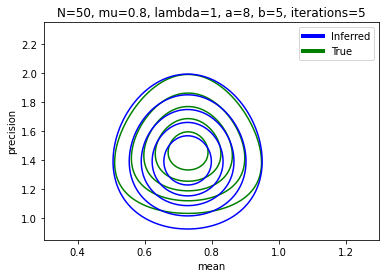

In [ ]:
iter = 5
m, l, a, b = 0, 0, 0, 0

m, l, a, b = VariationalInference(m, l, a, b, X, iter)

custom_lines = [Line2D([0], [0], color="blue", lw=4),
                Line2D([0], [0], color="green", lw=4)]

fig, ax = plt.subplots()
ax.legend(custom_lines, ['Inferred', 'True'])
true_plot(true_mu, true_lam, true_a, true_b, X)
plot(m, l, a, b)
plt.xlabel("mean")
plt.ylabel("precision")
plt.title('N=50, mu=0.8, lambda=1, a=8, b=5, iterations=5')

plt.show()